Best BO hyperparameters: [np.int64(61), np.int64(2), 0.1136243256804193, 0.0022065489240911344, np.int64(153)]
Best BO validation accuracy: 0.9833333333333333
Best Random Search validation accuracy: 0.9888888888888889


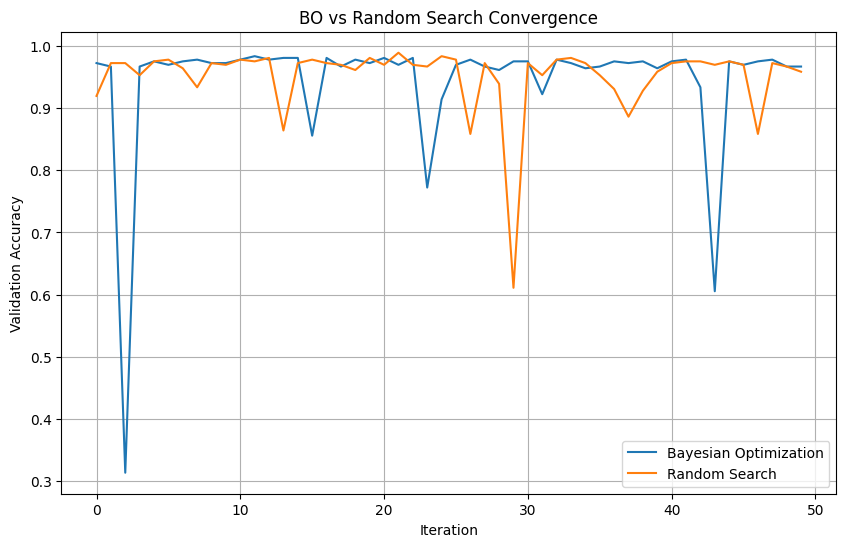

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import os

import torch
import torch.nn as nn
import torch.optim as optim

!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# -----------------------------
# Dataset
# -----------------------------
digits = load_digits()
X, y = digits.data, digits.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# -----------------------------
# Model
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hidden_dim
        layers.append(nn.Linear(dim, len(np.unique(y))))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# -----------------------------
# Training function
# -----------------------------
def train_model(hidden_dim, num_layers, dropout, lr, batch_size, epochs=20):
    model = MLP(X_train.shape[1], hidden_dim, num_layers, dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Explicitly cast batch_size to int to avoid potential type issues with DataLoader
    batch_size = int(batch_size)

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val)
        val_acc = accuracy_score(y_val.numpy(), preds.argmax(dim=1).numpy())
    return -val_acc  # gp_minimize minimizes

# -----------------------------
# Search space
# -----------------------------
space = [
    Integer(32, 256, name='hidden_dim'),
    Integer(1, 3, name='num_layers'),
    Real(0.0, 0.5, name='dropout'),
    Real(1e-4, 1e-2, name='lr'),
    Integer(32, 256, name='batch_size')
]

@use_named_args(space)
def objective(hidden_dim, num_layers, dropout, lr, batch_size):
    return train_model(hidden_dim, num_layers, dropout, lr, batch_size)

# -----------------------------
# Bayesian Optimization
# -----------------------------
res_gp = gp_minimize(objective, space, n_calls=50, random_state=42)
print("Best BO hyperparameters:", res_gp.x)
print("Best BO validation accuracy:", -res_gp.fun)

# -----------------------------
# Random Search
# -----------------------------
random_losses = []
for i in range(50):
    hidden_dim = np.random.randint(32, 257)
    num_layers = np.random.randint(1, 4)
    dropout = np.random.uniform(0.0, 0.5)
    lr = 10 ** np.random.uniform(-4, -2)
    batch_size = np.random.randint(32, 257)
    loss = train_model(hidden_dim, num_layers, dropout, lr, batch_size)
    random_losses.append(loss)

print("Best Random Search validation accuracy:", -min(random_losses))

# -----------------------------
# Convergence Plot
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(-np.array(res_gp.func_vals), label="Bayesian Optimization")
plt.plot(-np.array(random_losses), label="Random Search")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("BO vs Random Search Convergence")
plt.legend()
plt.grid(True)

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)
plt.savefig("results/convergence.png")
plt.show()